In [ ]:
!pip install tensorflow

Importando libs

In [47]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Extraindo zip com imagens

In [35]:
!unzip /content/drive/MyDrive/kagglecatsanddogs_5340.zip -d /content/cats_and_dogs

Archive:  /content/drive/MyDrive/kagglecatsanddogs_5340.zip
replace /content/cats_and_dogs/PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [36]:
train_dir = "/content/cats_and_dogs/PetImages"
cat_dir = os.path.join(train_dir, 'Cat')
dog_dir = os.path.join(train_dir, 'Dog')

Verificando número de amostras de gatos e cachorros

In [37]:
print(f"Cats image length: {len(os.listdir(cat_dir))}")
print(f"Dogs image length: {len(os.listdir(dog_dir))}")

Cats image length: 12501
Dogs image length: 12501


removendo imagens erradas, isso foi necessario 😞

In [38]:
def clean_dataset(directory):
    for category in ['Cat', 'Dog']:
        folder_path = os.path.join(directory, category)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Removing damaged file: {file_path}")
                os.remove(file_path)

In [39]:
clean_dataset(train_dir)

Removing damaged file: /content/cats_and_dogs/PetImages/Cat/666.jpg
Removing damaged file: /content/cats_and_dogs/PetImages/Cat/Thumbs.db


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removing damaged file: /content/cats_and_dogs/PetImages/Dog/Thumbs.db
Removing damaged file: /content/cats_and_dogs/PetImages/Dog/11702.jpg


In [40]:
print(f"Cats image length: {len(os.listdir(cat_dir))}")
print(f"Dogs image length: {len(os.listdir(dog_dir))}")

Cats image length: 12499
Dogs image length: 12499


pre processing das imagens

In [41]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


construção do modelo

In [42]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

<ipython-input-42-d68d1b1f6d16>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

treino do modelo

In [43]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 702s 1s/step - accuracy: 0.8616 - loss: 0.2859 - val_accuracy: 0.9185 - val_loss: 0.1814
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.3129
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 669s 1s/step - accuracy: 0.9211 - loss: 0.1872 - val_accuracy: 0.9301 - val_loss: 0.1625
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0335
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 650s 1s/step - accuracy: 0.9249 - loss: 0.1709 - val_accuracy: 0.9257 - val_loss: 0.1718
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0252
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.9323 - loss: 0.1634 - val_accuracy: 0.9309 - val_loss: 0.1638
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.3215
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.9289 - 

visualização de métricas

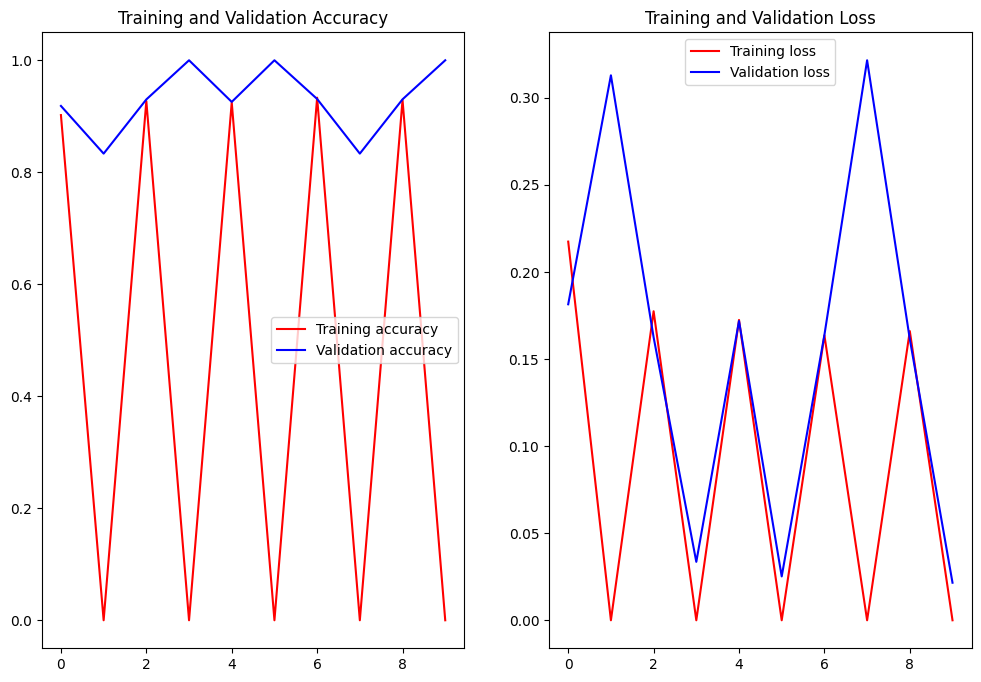

In [44]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

prevendo novas imagens

In [51]:
def predict_image(model, image_path):
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0


    prediction = model.predict(img_array)
    label = "Dog" if prediction[0][0] > 0.5 else "Cat"

    print(f"Prediction: {label} (Confidence: {prediction[0][0]:.2f})")
    plt.imshow(img)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction: Cat (Confidence: 0.00)


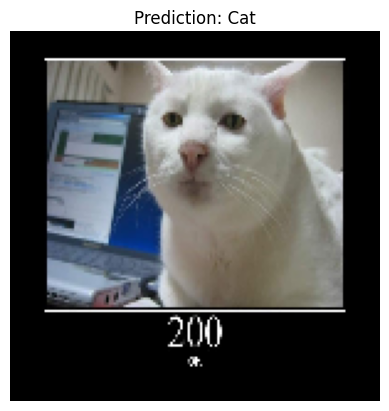

In [52]:
image_path_cat = "/content/200.jpg"
predict_image(model, image_path_cat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: Dog (Confidence: 1.00)


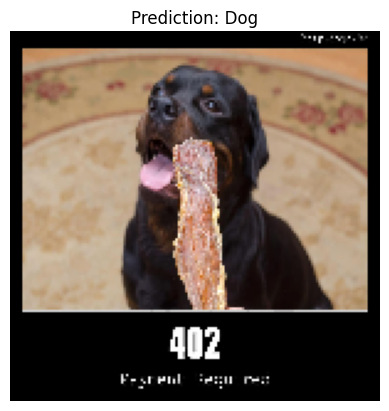

In [53]:
image_path_dog = "/content/402.jpg"
predict_image(model, image_path_dog)